In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

In [2]:
from cycler import cycler
import matplotlib

# Set the color cycle
#plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#c7463d', '#ffad08', '#6f73b0', '#56b4e9', '#4c6e3d', '#c47ca2', '#f5f575']))
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))

# Configure Matplotlib to use LaTeX fonts
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"

# Set font sizes
matplotlib.rcParams.update(
    {
        "font.size": 16,  # General font size
    }
)

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['Events;1']
    data = tree.arrays(library="np")
    return data

First test of lgatr on 1 mio data fastsim CLD - didn't track the training so weeeell. But here we go:

In [5]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/lgatr/test_lgatr-fastsimCLD.root"

data1 = load_data(path1)
data2 = load_data(path2)

In [7]:
def invalid_ind(data):
    ind = []
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    for l in labels: 
        true_labels = data[f'recojet_is{l}']
        scores = data[f'score_recojet_is{l}']
        valid_indices = np.where(np.isnan(scores))
        ind.append(valid_indices)
    return np.unique(ind)

In [8]:
def get_y_true_and_score(data):
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    y_true = np.array([data[f'recojet_is{label}'] for label in labels])
    y_true = np.argmax(y_true.T, axis=1)
    y_score = np.array([data[f'score_recojet_is{label}'] for label in labels])
    #print(y_score.shape)
    ind_nan = invalid_ind(data)
    #print(ind_nan)
    #print(ind_nan.shape)
    y_score = np.delete(y_score, ind_nan, axis=1)
    y_true = np.delete(y_true, ind_nan)
    return y_true, y_score.T

In [45]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    #print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    #print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities using softmax
        y_scores_pos_prob = y_score_selected_positive / (np.sum(
            y_score_selected_positive, axis=1, keepdims=True
        ) + 1e-10)
        mysum = np.sum(
            y_score_selected_positive, axis=1, keepdims=True
        )
        if np.any(mysum < 0.0001):
            print(mysum[np.where(mysum <0.0001)])
        y_scores_neg_prob = y_score_selected_negative / (np.sum(
            y_score_selected_negative, axis=1, keepdims=True
        )+ 1e-10)

        # Ensure non-zero sums with clipping
        sum_pos = np.clip(np.sum(y_score_selected_positive, axis=1, keepdims=True), 1e-10, None)
        y_scores_pos_prob = y_score_selected_positive / sum_pos

        sum_neg = np.clip(np.sum(y_score_selected_negative, axis=1, keepdims=True), 1e-10, None)
        y_scores_neg_prob = y_score_selected_negative / sum_neg

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]



        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score
        #print("y_true_: ", y_true_, 'shape:', y_true_.shape) # ever entry that's a MC b quark
        #print("y_prob_positive: ", y_prob_positive, 'shape:', y_prob_positive.shape) # how high is the probability that this is a b quark? (normed by the probabitiy for being a b and c quark?)
        fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
        auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]#, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


In [41]:
def create_binary_rocs(positive, negative, y_true, y_score): # old version
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative

    number_positive = np.sum(mask_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative])

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]

        y_score_negative = y_score[mask_negative]
        indices = np.array([negative, positive])
        y_score_selected_positive = y_score_positive[:, indices]
        y_score_selected_negative = y_score_negative[:, indices]

        # Calculate probabilities using softmax
        y_scores_pos_prob = np.exp(y_score_selected_positive) / np.sum(
            np.exp(y_score_selected_positive), axis=1, keepdims=True
        )
        y_scores_neg_prob = np.exp(y_score_selected_negative) / np.sum(
            np.exp(y_score_selected_negative), axis=1, keepdims=True
        )

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1]
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        # Compute ROC curve and AUC score
        fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
        auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]
    else:
        return []

In [46]:
def log_multiline_rocs_b(y_true, y_score, labels, ax, k,j, ls="solid", l=True):
    q_tag = 4 # b-tagging
    vs_tag = [1,2, 5] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)


    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        # Calculate TPR for different ROC curves (this function needs to be defined elsewhere)
        #calculate_and_log_tpr_1_10_percent(_bg[0], _bg[1], "b", "g")
        #calculate_and_log_tpr_1_10_percent(_bud[0], _bud[1], "b", "ud")
        #calculate_and_log_tpr_1_10_percent(_bc[0], _bc[1], "b", "c")

        # Plot ROC curves
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k,j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k,j].grid()
        ax[k,j].set_ylim(-3, 0)
        ax[k,j].set_xlabel("jet tagging efficiency")
        ax[k,j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_c(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 2 # b-tagging
    vs_tag = [1,4, 5] # ud, b, g
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

def log_multiline_rocs_s(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 3 # s-tagging
    vs_tag = [1,2, 4, 5] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_g(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 5 # g-tagging
    vs_tag = [1,2, 3, 4] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [47]:
def all_rocs(label1, label2, save=False, name=None):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label=label1)
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label=label2)

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.6, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/{}.pdf".format(name))
    plt.show()

[3.9482504e-05]
[4.4501856e-05]
[4.3838067e-05]
[6.1958432e-05 5.1404008e-05 8.7266148e-05 4.9232491e-05 6.8805959e-05]
[7.198179e-05 8.161336e-05]
[6.100673e-05]
[0.000000e+00 5.898268e-05]
[5.6045224e-06 3.5589237e-05 3.6268816e-06 1.2874534e-06 6.5497593e-06
 7.9014739e-05 1.2158006e-07 3.5033595e-06 4.4785898e-07 1.5172245e-05
 3.4645041e-06 4.2561478e-05 1.5259138e-06 8.9020020e-08 3.7812500e-09
 4.6608630e-08 2.3195907e-06 5.1885017e-06 1.8300818e-05 1.7920943e-06
 1.2428522e-06 5.5630682e-08 5.2651706e-07 0.0000000e+00 2.7568728e-06
 4.0342755e-07 2.8273909e-05 3.7321042e-06 3.8243157e-05 2.5115442e-06
 1.3782562e-06 1.3659684e-07 1.4616614e-06 7.8794956e-06 7.3876651e-09
 1.2590157e-06 1.0897106e-05 1.2918281e-06 7.7517625e-06 5.1636220e-05
 3.5928941e-05]
[1.0747959e-42 8.6667496e-05]


/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019

[9.2905661e-10 1.0328457e-14 0.0000000e+00]
[5.30494399e-05 5.03816882e-05 1.54785794e-05 5.37873939e-06
 8.83098328e-05 3.37789606e-06 9.25181594e-05 1.23354839e-05
 2.93937337e-05 7.67841993e-06 4.27866471e-05 8.40685355e-10
 4.11961191e-05 2.48214947e-05 7.31231466e-08 7.99500995e-05
 8.42513373e-07 1.13107248e-08 9.68142267e-05 4.91070205e-06
 3.43675201e-05 3.57722882e-08 1.24261433e-07 2.34710242e-08
 7.22606055e-05 7.16415816e-05 2.30670576e-05 6.54263713e-05
 6.35848210e-06 4.35429172e-07 1.36355470e-06 4.32841152e-05
 9.65155414e-06 7.14091802e-05 1.74075990e-06 7.81072304e-05
 4.81610252e-10 1.72226046e-05 4.82476821e-07 7.15945498e-05
 4.06512163e-06 8.43586531e-06 3.53248470e-05 6.26047703e-09
 7.57818498e-06 2.35761561e-08 6.10850766e-05 3.60097863e-09
 3.34189144e-06 1.32920366e-06 7.81688414e-06 5.84963322e-09
 9.29076538e-10 1.91223353e-05 3.05435108e-08 5.67172247e-05
 1.50284257e-06 2.94325815e-07 6.18840613e-06 4.07168166e-08
 1.11361544e-06 1.91200397e-05 2.22034842

/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019

[1.74384606e-12 3.56638874e-09 3.18214625e-05 7.27751887e-21
 4.57799920e-15 3.75940945e-05 4.99350381e-06 2.77487779e-05
 9.33844035e-07 3.26194323e-12 8.95955532e-12 4.02066364e-21
 3.12262586e-07 1.72327236e-06 2.64451785e-08 3.99905330e-05
 6.09091614e-07 6.26565772e-15 5.38965082e-07 4.66540296e-05
 3.14793567e-07 2.01595249e-05 2.08746229e-08 2.07462728e-10
 1.45790318e-05 3.81826430e-06 6.16142934e-05 5.84823628e-16
 3.90582227e-06 8.44105674e-10 3.68392393e-05 7.66569750e-13
 1.60068514e-17 4.90341627e-05 2.57150707e-11 1.19720396e-19
 1.12805556e-05 5.35635181e-09 1.00185502e-17 2.74240701e-05
 1.47832777e-08 4.65714111e-05 1.44817434e-07 4.42148594e-05
 1.74516028e-08 1.93276373e-05 1.57986074e-06 1.40940847e-06
 6.71908720e-06 1.02140598e-06 2.10064921e-09 8.01310893e-11
 3.31189283e-18 3.21990394e-12 5.52108540e-05 3.46182167e-17
 1.07864509e-10 8.57513533e-06 3.58333949e-07 4.34495192e-12
 3.12500351e-13 1.11996842e-10 1.80186676e-18 1.91668132e-05
 1.44510492e-09 1.900960

/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_101

[5.3327196e-05]
[8.1561608e-05 3.7603753e-05 8.3532548e-05 3.4904984e-05 3.2593878e-05
 3.6134890e-05 8.8316432e-05 8.7826804e-05 8.3590880e-05 7.5960626e-05
 7.9879384e-05 9.4981813e-05]
[3.182873e-05 4.779853e-07]


/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_10

[3.8729897e-05 1.6970790e-06]
[3.1828731e-05 4.7798528e-07 9.8724908e-05 9.1689421e-05 9.9186465e-05]


/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:47: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))
/tmp/ipykernel_1019641/274795317.py:48: RuntimeWarning: divide by zero encountered in log10
  log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))


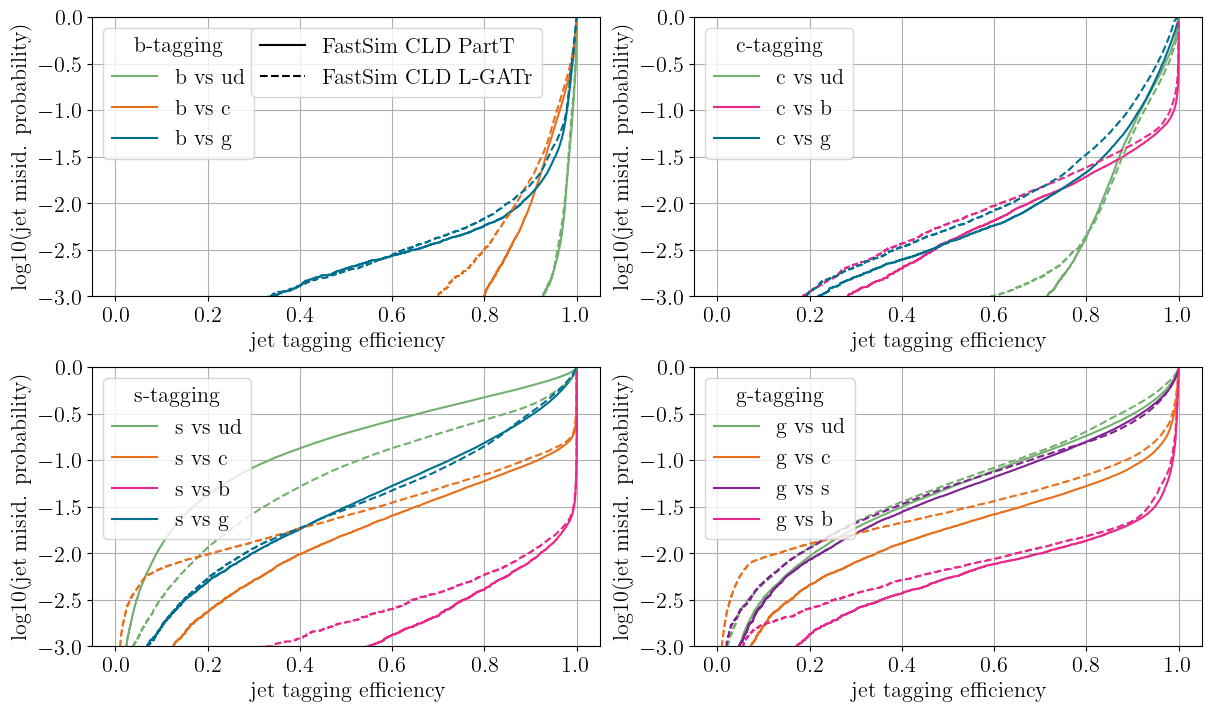

In [48]:
all_rocs('FastSim CLD PartT', 'FastSim CLD L-GATr', save=False)